# ML - Ensemble Learning

La técnica de aprendizaje ensamblado, o *Ensemble Learning* en inglés, consiste en combinar diferentes modelos de ML para obtener mejores predicciones que las que nos proporcionarían los diferentes modelos por separado. Existen multitud de técnicas de ensamblado, y en este post veremos las siguientes:

- Clasificadores por votación
- *Bagging* y *Pasting*
- *Random Forest*
- *Boosting*
- *Stacking*

## Clasificadores por votación

Esta es una de las técnicas de ensamblado más sencillas, y como su propio nombre indica simplemente agregaremos las predicciones de diferentes clasificadores quedándonos con la clase más votada.

![](https://cdn-images-1.medium.com/max/1000/0*c0Eg6-UArkslgviw.png)

En *Scikit-Learn* puedes usar el objeto [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html), que usamos en el siguiente ejemplo en el que ensamblamos un modelos de regresión logística, un SVM y un árbol de decisión (todos explicados en posts anteriores).

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)
tree_cf = DecisionTreeClassifier(max_depth=2, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf), ('rf', tree_cf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('rf',
                              DecisionTreeClassifier(max_depth=2,
                                                     random_state=42))])

Cada modelos por separado es capaz de dar su predicción, el modelo ensamblado asignará, para cada instancia de test, aquella clase con mayor número de votos. De esta manera, el modelo resultante tiene mejor prestaciones que ninguno de los modelos por sí mismos ya que los errores que un modelo pueda cometer, los otros lo pueden aliviar. Es por esta motivo que cuanto mayor diversidad de modelos tengamos en el ensamblado (mayor diversidad en los errores), mejores prestaciones tendrá el ensamblado final.

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, tree_cf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.896
SVC 0.896
VotingClassifier 0.904


Este método de clasificación por votación se conoce como *hard voting*, escoger la clase más votada. Sin embargo, promediar las probabilidades que obtenemos de los diferentes modelos y escoger aquella clase con mayor probabilidad suele dar mejores resultados. Este proceso se conoce como *soft voting*.

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", random_state=42, probability=True)
tree_cf = DecisionTreeClassifier(max_depth=2, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svc', svm_clf), ('rf', tree_cf)],
    voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, tree_cf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.896
SVC 0.896
VotingClassifier 0.904


## *Bagging* y *Pasting*

Otra alternativa a la hora de aplicar aprendizaje ensamblado consiste en usar el mismo modelo, pero entrenado con diferentes subsets del dataset de entrenamiento (como ya hicimos en el post anterior en una primera introducción a los *Random Forest*). Si cada modelo es entrenado con un subset único, la técnica se llama *pasting*. En caso contrario, se llama *bagging* (abreviación de *bootstrap aggregating*), lo cual es más común y la técnica usada en los *Random Forest* (útil sobretodo en datasets pequeños).

![](https://makineogrenimi.files.wordpress.com/2017/06/ensemble3.png?w=656)

Una vez los modelos han sido entrenados, se pueden sacar predicciones agregando las predicciones de todos los modelos mediante un mecanismo de votación como el que hemos visto en la sección anterior (o promediando los valores en una tarea de regresión).

Veamos un ejemplo usando el objeto [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html?highlight=baggingclassifier#sklearn.ensemble.BaggingClassifier) de *Scikit-Learn* para entrenar un ensamblado de árboles de decisión con esta técnica.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42, oob_score=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


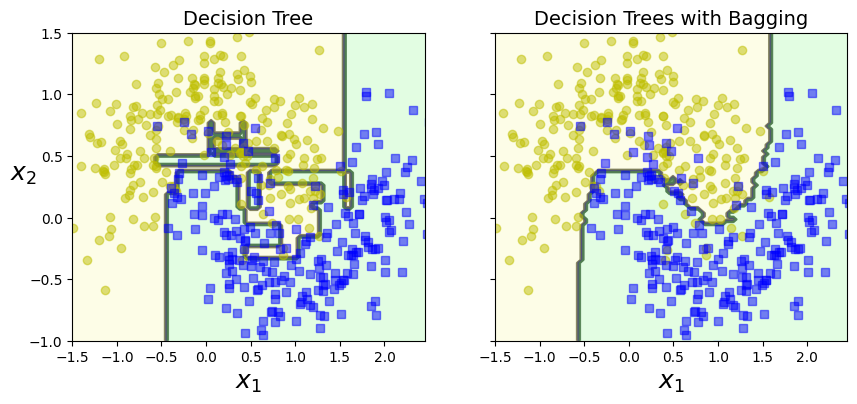

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

## *Random Forest*

Como ya vimos en el post anterior, un *Random Forest* no es más que un ensamblado de árboles de decisión entrenados usando la técnica de *bagging*. En *Scikit-Learn*, puedes usar el modelo [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier) directamente.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

Una de las cualidades más interesantes de los *Random Forest* es la capacidad de medir la importancia relativa de cada característica, midiendo la cantidad en la que los nodos de los árboles reducen, en promedio, la impureza (concept detallado en el post anterior). Ésto hace que los *Random Forest* sean muy útiles para la tarea de *feature engineering* o aplicaciones en las que la explicabilidad del modelo sea de importancia vital.

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


Vamos a ver un ejemplo más ilustrativo usando el dataset MNIST. ¿Podemos saber cuáles son los píxeles más importantes a la hora de clasificar un dígito en una imagen?

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


RandomForestClassifier(random_state=42)

In [ ]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

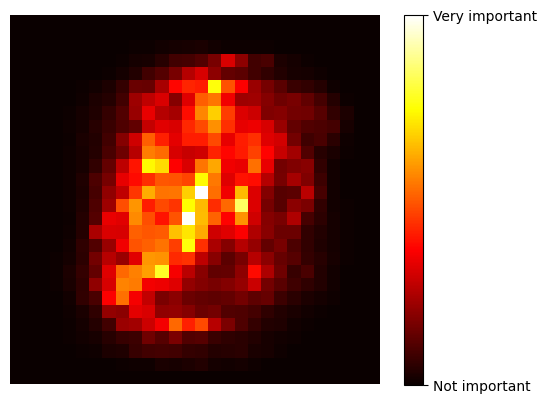

In [ ]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

## *Boosting*

La técnica de *Boosting* consiste en entrenar modelos de manera secuencial, cada uno intentando corregir los errores del modelos predecesor. Las técnicas de *boosting* más populares son *AdaBoost* y *Gradient Boosting*.

### *AdaBoost*

En la técnica de *AdaBoost* cada modelo intenta corregir a su predecesor prestando más atención a las muestras de entrenamiento a las cuales el modelo anterior hizo *underfitting*. Empieza entrenando un clasificador básico, el cual es utilizado para hacer predicciones en los datos de entrenamiento. Entonces, el algoritmo aumenta la importancia relativa de aquellas muestras que han sido clasificadas erróneamente. Después, se entrena un segundo clasificador utilizando estos nuevos pesos y así sucesivamente. Una vez todos los modelos han sido entrenados, se hace una predicción en ensamblado de votación con la diferencia de que cada predicción lleva asociada un peso que depende de su precisión promedia en el dataset modificado. En *Scikit-Learn* podemos usar el objeto [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboostclassifier#sklearn.ensemble.AdaBoostClassifier).

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

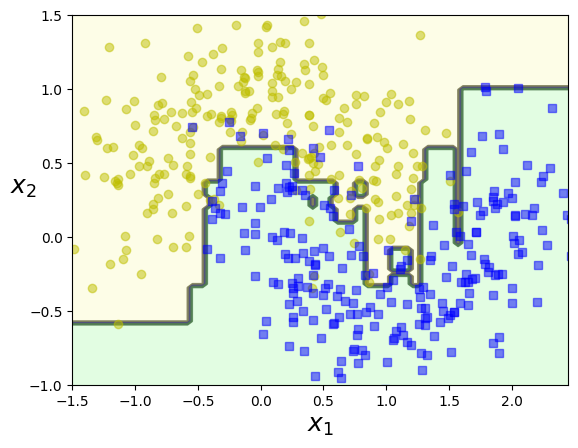

In [ ]:
plot_decision_boundary(ada_clf, X, y)

El siguiente código ilustra una simplificación del funcionamiento del algoritmo, entrenando un SVC de manera consecutiva ajustando los pesos relativos de aquellas muestras clasificadas erróneamente.

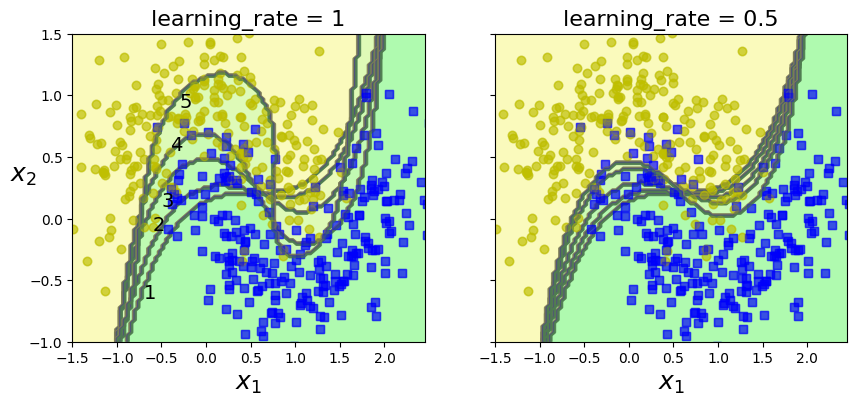

In [ ]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

### *Gradient Boosting*

De la misma manera que *AdaBoost*, *Gradient Boosting* consiste en entrenar modelos de manera secuencial, cada uno corrigiendo los errores del anterior. La diferencia es que, en vez de ajustar la importancia de las muestras mal clasificadas, cada modelo se entrena con el error residual del modelo anterior. Para ilustrar este algoritmo, primero entrenamos un árbol de decisión en el siguiente dataset para la tarea de regresión.

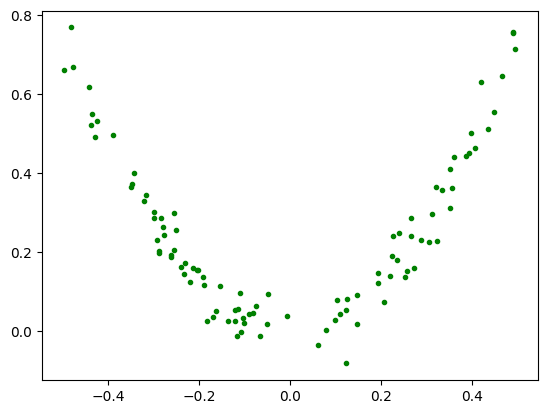

In [ ]:
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
plt.plot(X,y,'.g')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Ahora, podemos calcular el error residual de la siguiente manera.

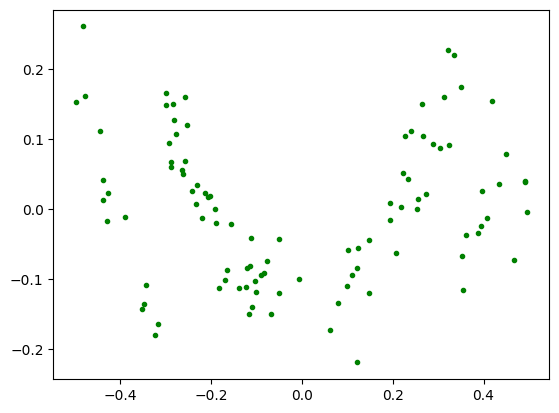

In [ ]:
y2 = y - tree_reg1.predict(X)
plt.plot(X,y2,'.g')

El nuevo modelo será entrenado con este error residual.

In [ ]:
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Y así de manera consecutiva.

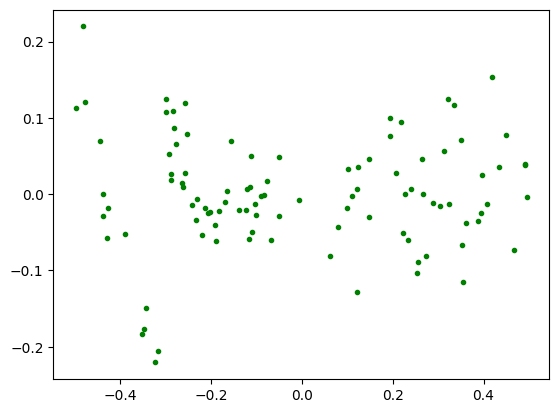

In [ ]:
y3 = y2 - tree_reg2.predict(X)
plt.plot(X,y3,'.g')

In [ ]:
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

La predicción final será la suma de las predicciones de todos los modelos por separado.

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

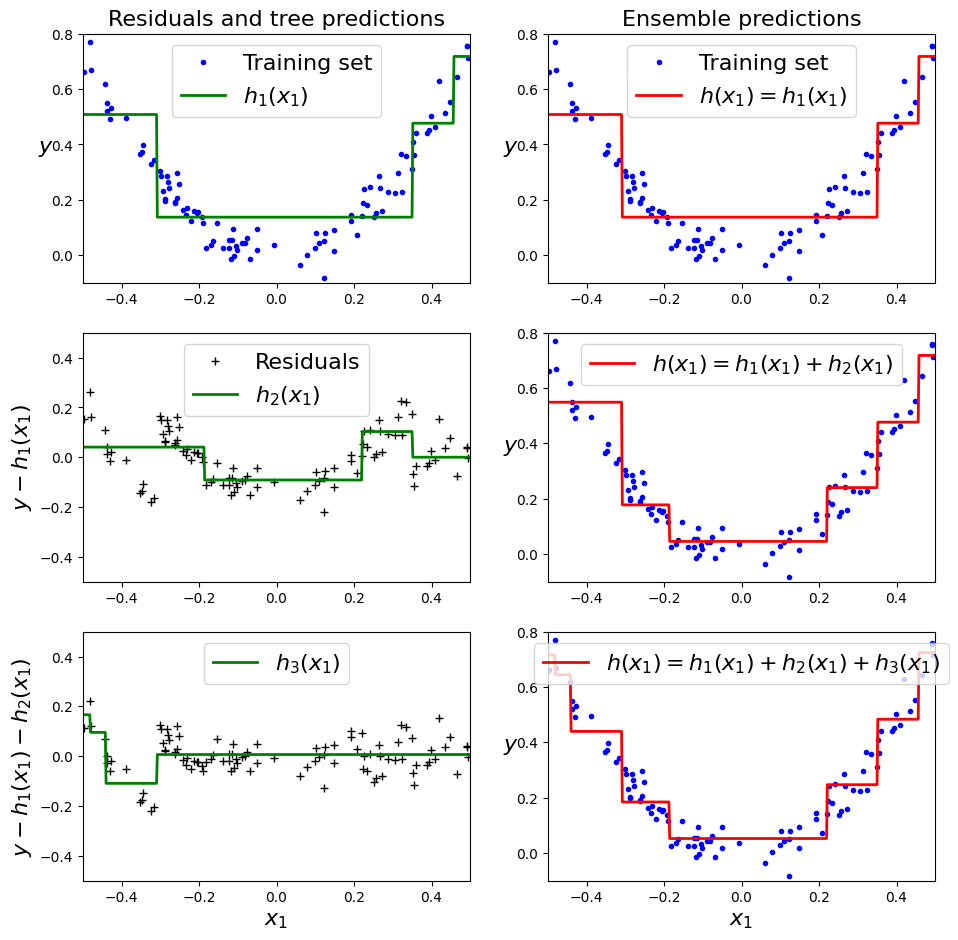

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

En *Sickit-Learn* podemos usar el objeto [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html?highlight=gradientboostingregressor#sklearn.ensemble.GradientBoostingRegressor)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

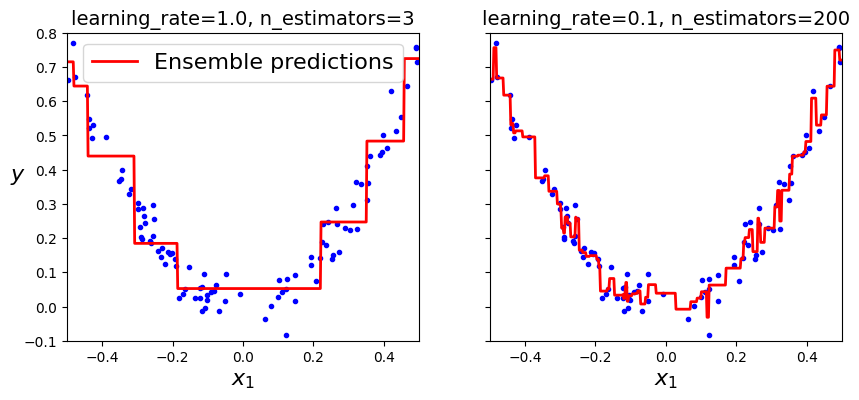

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

Los modelos de *Gradient Boosting* son muy propensos al *overfitting*, por lo que usar técnicas de regularización como el *early stopping* para encontrar el número óptimo de árboles de decision en el modelo es aconsejable.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=400, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=94, random_state=42)

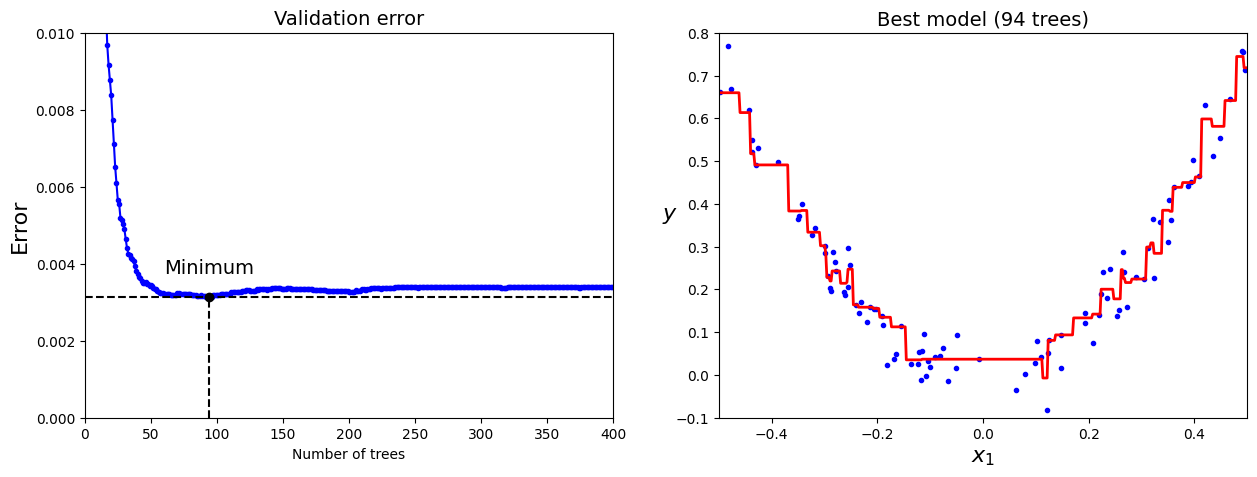

In [ ]:
min_error = np.min(errors)

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 400], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 400, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

Estos algoritmos son muy potentes y populares, sobretodo en competiciones en [Kaggle](https://www.kaggle.com/) y plataformas similares. En ellas, una implementación popular de estos algoritmos se encuentra en la librería [XGBoost](https://xgboost.readthedocs.io/en/latest/), diseñada y optimizada para este tipo de modelos de ML.

> Para instalar la librería, usa el comando `pip install xgboost`.

In [ ]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

Validation MSE: 0.00501425152487392


In [ ]:
xgb_reg = xgboost.XGBRegressor(random_state=42, early_stopping_rounds=2)
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)
print("Validation MSE:", val_error)

[0]	validation_0-rmse:0.18326
[1]	validation_0-rmse:0.14867
[2]	validation_0-rmse:0.12793
[3]	validation_0-rmse:0.11112
[4]	validation_0-rmse:0.09966
[5]	validation_0-rmse:0.09083
[6]	validation_0-rmse:0.08362
[7]	validation_0-rmse:0.07958
[8]	validation_0-rmse:0.07677
[9]	validation_0-rmse:0.07499
[10]	validation_0-rmse:0.07337
[11]	validation_0-rmse:0.07265
[12]	validation_0-rmse:0.07166
[13]	validation_0-rmse:0.07139
[14]	validation_0-rmse:0.07079
[15]	validation_0-rmse:0.07038
[16]	validation_0-rmse:0.07037
[17]	validation_0-rmse:0.07037
[18]	validation_0-rmse:0.07041
Validation MSE: 0.004951367717904832


## *Stacking*

El último método de ensamblado que veremos en este post es el conocido como *stacking*. Todos los métodos de ensamblado vistos hasta ahora usan algún tipo de mecanismo de votación para generar las predicciones finales. El *stacking* consiste, sin embargo, en usar un modelo de ML para generar las predicciones finales, usando las predicciones de los modelos individuales como entradas.

![](https://i.stack.imgur.com/K7tyy.png)

Es posible incluso usar múltiples capas de modelos en el *stacking*, lo cual nos recuerda a las redes neuronales.

![](https://img2018.cnblogs.com/blog/1012590/201904/1012590-20190404172104244-488517607.png)

Deafortunadamente, *Scikit-Learn* no soporta esta modalidad de ensamblado, así que te toca a ti implementar esta funcionalidad si quieres probarla 😛. Vamos a ver un ejemplo sencillo usando el dataset MNIST.

In [ ]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target,
              test_size = 10000, random_state = 42, stratify=mnist.target)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
              test_size = 10000, random_state = 42, stratify=y_train)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((50000, 784), (10000, 784), (10000, 784))

Primero, entrenaremos varios clasificadores.

> Usaremos un [ExtraTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), una variante del *Random Forest* en la que los valores usados para dividir los datos en cada nodo son aleatorios en vez de calculados. Esto hace que sean mucho más rápidos de entrenar y menos susceptibles al *overfitting*.

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC

svm_clf = LinearSVC(random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)

estimators = [svm_clf, rf_clf, et_clf]

for estimator in estimators:
  estimator.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
for estimator in estimators:
  print(estimator.score(X_val, y_val))

0.878
0.9709
0.9731


Vamos ahora a combinar los modelos. En primer lugar, podemos usar un clasificador por votación simple.

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('et', et_clf), ('rf', rf_clf), ('svc', svm_clf)],
    voting="hard"
)

voting_clf.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


VotingClassifier(estimators=[('et', ExtraTreesClassifier(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', LinearSVC(random_state=42))])

In [ ]:
voting_clf.score(X_val, y_val)

0.9712

Y, por último, vamos a hacer el *stacking*. Para ello, deberemos generar predicciones en el dataset de validación para generar el dataset de entrenamiento del modelo que generará la predicción final.

In [ ]:
X_val_predictions = np.zeros((len(X_val), len(estimators)))

for i, estimator in enumerate(estimators):
  X_val_predictions[:,i] = estimator.predict(X_val)

Usaremos un *Random Forest* en la última capa del *stacking* (el *blender* o mezclador).

In [ ]:
rf_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rf_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [ ]:
rf_blender.oob_score_

0.9717

Ahora ya podemos evaluar nuestro modelos ensamblado con los datos de test.

In [ ]:
X_test_predictions = np.zeros((len(X_test), len(estimators)))

for i, estimator in enumerate(estimators):
  X_test_predictions[:,i] = estimator.predict(X_test)

y_pred = rf_blender.predict(X_test_predictions)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9682

In [ ]:
voting_clf.score(X_test, y_test)

0.9669

Hemos visto varias técnicas de ensamblado para ML, consistentes en combinar varios modelos en vez de usar sólo uno para obtener así mejores resultados. Esta técnica es muy usada en competiciones ya que permite obtener unas prestaciones extra gratis simplemente combinando modelos. De entre las diferentes técnicas de ensamblado hemos introducido los clasificadores por votación, que combinan las predicciones de varios modelos quedándose con aquella más común, técnicas de *bagging* y  los *Random Forest*, que consisten en entrenar diferentes modelos con diferentes subsets de los datos de entrenamiento para luego generar una única predicción mediante un mecanismo de votación, técnicas de *boosting* (como *AdaBoost* o *Gradient Boosting*) que se basan en la idea de entrenar modelos de manera consecutiva, cada uno corrigiendo los errores del anterior, y, por último, la técnica del *stacking* que, a diferencia de los mecanismos de votación, utilizan otros modelos de ML para combinar las predicciones de los modelos del ensamblado.  